# Fig 3: variable aperiodic activity gif

This notebook creates an animated visualizer showing how dynamic aperiodic activity can influence estimates.

Based on Fig 3 (c-e) of the oscillation methods paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from fooof import Bands
from fooof.utils import trim_spectrum
from neurodsp.spectral import compute_spectrum

from neurodsp.plts.utils import check_ax

from neurodsp.sim import sim_powerlaw, sim_oscillation

In [2]:
import seaborn as sns
sns.set_context('poster')

In [3]:
# Import custom code
from code.utils import sweep_values
from code.sim import rotate_sig
from code.measures import compute_abs_power, compute_rel_power
from code.plts import plot_bar, plot_band_bars, plot_spectra
from code.gif import clear_output, _gif_plot_output

## SETTINGS

In [4]:
# Simulated data settings
n_seconds = 25
fs = 1000

exp = -1
cf = 10

exp_rot = 0.1
f_rotation = 10

In [5]:
# Define band definitions
BANDS = Bands({'delta' : [2, 4],
               'theta' : [4, 8],
               'alpha' : [8, 13],
               'beta' : [13, 30],
               'gamma' : [30, 80]})

# Define band colors, for shading
BAND_COLORS = {'delta' : '#e8dc35',
               'theta' : '#46b870',
               'alpha' : '#1882d9',
               'beta'  : '#a218d9',
               'gamma' : '#e60026'}

shade_colors = [BAND_COLORS[band] for band in BANDS.labels]

ALPHA_RANGE = (8, 12)
full_range = [2, 50]

In [6]:
# Plot settings
c1 = '#0000ff'
c2 = '#00693a'
colors = [c1, c2]

PLT_RANGE = [2, 50]
ylim_sp = [-3.5, -0.5]
ylim_band = [-0.2, 0.2]

In [7]:
# Define rotations to sweep across
mid, low, high = 0, -0.5, 0.5
step = 0.1
rotations = sweep_values(mid, low, high, step, round_vals=2)

In [8]:
# Set whether to save out
SAVE = False

## DEFINE AXES

In [9]:
def make_axes():
    
    fig = plt.figure(figsize=(12, 4), constrained_layout=True)
    gs = fig.add_gridspec(2, 6)
    ax1 = fig.add_subplot(gs[0:, 0:2])
    ax2 = fig.add_subplot(gs[0:, 2:4])
    ax3 = fig.add_subplot(gs[0, 4:])
    ax4 = fig.add_subplot(gs[1, 4])
    ax5 = fig.add_subplot(gs[1, 5])
    
    return fig, ax1, ax2, ax3, ax4, ax5

## SIMULATE SIGNAL

In [10]:
# Create the initial signal
ap = sim_powerlaw(n_seconds, fs, exp)
osc = 0.35 * sim_oscillation(n_seconds, fs, cf)
sig1 = ap + osc

In [11]:
# Create a rotated copy of the signal
sig2 = rotate_sig(sig1, fs, exp_rot, f_rotation)

In [12]:
# Compute required measures
freqs1, powers1 = trim_spectrum(*compute_spectrum(sig1, fs), PLT_RANGE)
freqs2, powers2 = trim_spectrum(*compute_spectrum(sig2, fs), PLT_RANGE)

deltas = {}
for label, f_range in BANDS:
    deltas[label] = compute_abs_power(freqs1, powers1, f_range) - \
        compute_abs_power(freqs2, powers2, f_range)

abs1 = compute_abs_power(freqs1, powers1, ALPHA_RANGE)
abs2 = compute_abs_power(freqs2, powers2, ALPHA_RANGE)

tot1 = compute_abs_power(freqs1, powers1, full_range)
tot2 = compute_abs_power(freqs2, powers2, full_range)

rel1 = compute_rel_power(freqs1, powers1, ALPHA_RANGE, norm_range=full_range)
rel2 = compute_rel_power(freqs2, powers2, ALPHA_RANGE, norm_range=full_range)

## EXAMPLE PLOT

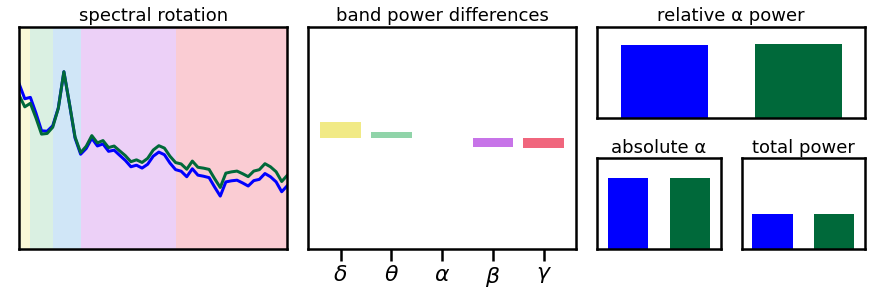

In [13]:
# Create an example panel of the visualizer
fig, ax1, ax2, ax3, ax4, ax5 = make_axes()
plot_spectra(freqs1, [powers1, powers2], log_freqs=False, colors=[c1, c2],
             shade_ranges=BANDS.definitions, shade_colors=shade_colors,
             xlim=PLT_RANGE, ylim=ylim_sp, ax=ax1)
ax1.set_title('spectral rotation', fontdict={'fontsize' : 18})
plot_band_bars(deltas, shade_colors, ylim=ylim_band, ax=ax2)
ax2.set_title('band power differences', fontdict={'fontsize' : 18})
plot_bar(rel1, rel2, color=[c1, c2], ylim=[0, 40], title='relative α power', ax=ax3)
plot_bar(abs1, abs2, color=[c1, c2], ylim=[0, 0.2], title='absolute α',  ax=ax4)
plot_bar(tot1, tot2, color=[c1, c2], ylim=[0, 1.25], title='total power', ax=ax5)

## BUILDER FUNCTION

In [14]:
def build_all(sig, rotations, sleep=0.10, save=False):
    
    ## Setup
    
    # Precompute measures for signal 1
    freqs1, powers1 = trim_spectrum(*compute_spectrum(sig, fs), PLT_RANGE)    
    abs1 = compute_abs_power(freqs1, powers1, ALPHA_RANGE)
    tot1 = compute_abs_power(freqs1, powers1, full_range)
    rel1 = compute_rel_power(freqs1, powers1, ALPHA_RANGE, norm_range=full_range)

    # Precompute the rotated signals
    rots = []
    for rotation in rotations:
        rots.append(rotate_sig(sig1, fs, rotation, f_rotation))

    # Precompute and collect the rotated signal measures
    powers2s, deltas, abs2s, tot2s, rel2s = [], [], [], [], []
    for rot in rots:
        
        freqs2, powers2 = trim_spectrum(*compute_spectrum(rot, fs), PLT_RANGE)
        powers2s.append(powers2)

        temp = {}
        for label, f_range in BANDS:
            temp[label] = compute_abs_power(freqs1, powers1, f_range) - \
                compute_abs_power(freqs2, powers2, f_range)
        deltas.append(temp)

        abs2s.append(compute_abs_power(freqs2, powers2, ALPHA_RANGE))
        tot2s.append(compute_abs_power(freqs2, powers2, full_range))
        rel2s.append(compute_rel_power(freqs2, powers2, ALPHA_RANGE, norm_range=full_range))
    
    ## Create builds
    for b_ind, (powers2, delta, abs2, tot2, rel2) in enumerate(zip(powers2s, deltas, abs2s, tot2s, rel2s)):
        
        clear_output(wait=True)
        
        # Make plot
        fig, ax1, ax2, ax3, ax4, ax5 = make_axes()
        plot_spectra(freqs1, [powers1, powers2], log_freqs=False, colors=[c1, c2],
                     shade_ranges=BANDS.definitions, shade_colors=shade_colors,
                     xlim=PLT_RANGE, ylim=ylim_sp, ax=ax1)
        ax1.set_title('spectral rotation', fontdict={'fontsize' : 18})
        plot_band_bars(delta, shade_colors, ylim=ylim_band, ax=ax2)
        ax2.set_title('band power differences', fontdict={'fontsize' : 18})
        plot_bar(rel1, rel2, color=[c1, c2], ylim=[0, 40], title='relative α power', ax=ax3)
        plot_bar(abs1, abs2, color=[c1, c2], ylim=[0, 0.2], title='absolute α', ax=ax4)
        plot_bar(tot1, tot2, color=[c1, c2], ylim=[0, 1.25], title='total power', ax=ax5)
    
        _gif_plot_output(fig, save, b_ind, 'fig3', sleep)

## ANIMATED PLOT

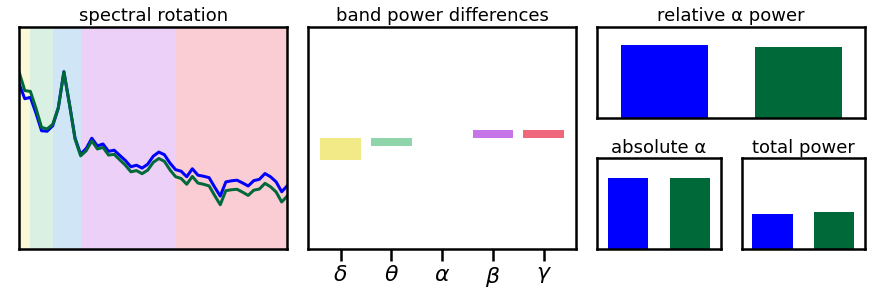

In [15]:
# Create the animated plot
build_all(sig1, rotations, save=SAVE)